In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader as dataloader
import torchvision.models as models

import time
import os
import random
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import trange, tqdm
import copy

from Trainer import ModelTrainer

In [2]:
# The size of our mini batches
batch_size = 64

# How many itterations of our dataset
num_epochs = 60

# Optimizer learning rate
learning_rate = 1e-4

# Where to load/save the dataset from 
data_set_root = "../../datasets"

# What to resize our images to 
image_size = 96

In [3]:
start_from_checkpoint = False

save_dir = '../data/Models'
model_name = 'ResNet18_STL10'

In [4]:
# Set device to GPU_indx if GPU is avaliable
GPU_indx = 0
device = torch.device(GPU_indx if torch.cuda.is_available() else 'cpu')

# Data Augmentation Transform
After training ResNet with no augmentations record the results, then implement the data augmentation. <br>
With a small dataset our large model will more then likely simply overfit to (or memorize) the training data which will often lead to bad evaluation results<br>
We can "create more" data from our limited dataset by applying random transformations as we sample images from our dataset instead of simply resizing them<br>
By applying these transformations we are also forcing our model to generalise better to unseen images<br>
You can also apply random affine transformations (shifts, scaling, rotations etc) - see <a href="https://pytorch.org/vision/0.12/transforms.html">Pytorch documentations</a>.<br>
NOTE: you should only apply transforms that make sense, eg if at test time you'll never see an upside-down cat, don't flip your images vertically 


In [5]:
# Prepare a composition of transforms
# A ll models from the Pytorch model Zoo where trained using images normalised with 
# the mean and std (one per channel) of the whole ImageNet Dataset
# therefore the pretrained feature "detectors" of the model will expect the input to 
# be normalized in the same way 
# https://pytorch.org/docs/stable/torchvision/models.html
train_transform = transforms.Compose([transforms.Resize(image_size),
                                      transforms.AutoAugment(),
                                      transforms.ToTensor(),
                                      transforms.RandomRotation(degrees=10),
                                      transforms.RandomHorizontalFlip(p=0.5),
                                      transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                           std=[0.229, 0.224, 0.225]),
                                     ])

transform = transforms.Compose([transforms.Resize(image_size),
                                transforms.ToTensor(),
                                transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                     std=[0.229, 0.224, 0.225])])

# Create the training, testing and validation data 

In [6]:
# Define our STL10 Datasets
# https://pytorch.org/docs/stable/torchvision/datasets.html#torchvision.datasets.STL10

# Dataset definition is a bit differenet to MNIST and CIFAR10
# STL10 has 3 different datasets, test, train and unlabeled
# http://ai.stanford.edu/~acoates/stl10/
# training set only has 5000 images and test set only 8000
# Image size in this dataset are 96x96, larger then what we've been using

train_data = datasets.STL10(data_set_root, split='train', download=True, transform=train_transform)
test_data = datasets.STL10(data_set_root, split='test', download=True, transform=transform)

# Split trainging data into train and validation set with 90/10% traning/validation split
validation_split = 0.9

n_train_examples = int(len(train_data)*validation_split)
n_valid_examples = len(train_data) - n_train_examples
train_data, valid_data = torch.utils.data.random_split(train_data, [n_train_examples, n_valid_examples],
                                                       generator=torch.Generator().manual_seed(42))

# Create the Pretrained Network

Use Pytorch's implementation of [ResNet18](https://pytorch.org/vision/0.14/models.html) with both randomly initialised weights and pretrained weights.

In [7]:
# Create a ResNet18 from the pytorch "models" module
# This is reasonably sized model at 18 layers deep
# ResNet Paper https://arxiv.org/pdf/1512.03385.pdf

# Create an instance of the ResNet18 Model
res_net = models.resnet18()

In [8]:
# Load a pre-trained model!
# SEE EXAMPLE 2 FOR MORE INFO!

# pretrained_model_name = "ResNet18_STL10_triplet"
# pretrained_model_trainer = ModelTrainer(model=res_net, output_size=64, device="cpu", 
#                                         loss_fun=nn.CrossEntropyLoss(), 
#                                         batch_size=batch_size, learning_rate=learning_rate, 
#                                         save_dir=save_dir, model_name=pretrained_model_name, 
#                                         start_from_checkpoint=True)

# res_net = copy.deepcopy(pretrained_model_trainer.model)

In [9]:
model_trainer = ModelTrainer(model=res_net.to(device), output_size=10, device=device, 
                             loss_fun=nn.CrossEntropyLoss(), 
                             batch_size=batch_size, learning_rate=learning_rate, 
                             save_dir=save_dir, model_name=model_name, 
                             start_from_checkpoint=start_from_checkpoint)

Starting from scratch


In [10]:
model_trainer.set_data(train_set=train_data, test_set=test_data, val_set=valid_data)

Number of training examples: 4500
Number of validation examples: 500
Number of testing examples: 8000


# Set a Learning Rate Scheduler
We can dynamically change the <a href="https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate">learning rate</a> during training to help our model converge to a better minimum!

In [11]:
# Uncomment one of these and try it out!

# model_trainer.set_lr_schedule(optim.lr_scheduler.StepLR(model_trainer.optimizer, 
#                                                         step_size=1, 
#                                                         gamma=0.95))

model_trainer.set_lr_schedule(optim.lr_scheduler.CosineAnnealingLR(model_trainer.optimizer, 
                                                                   T_max=num_epochs, 
                                                                   eta_min=0))

# View Data

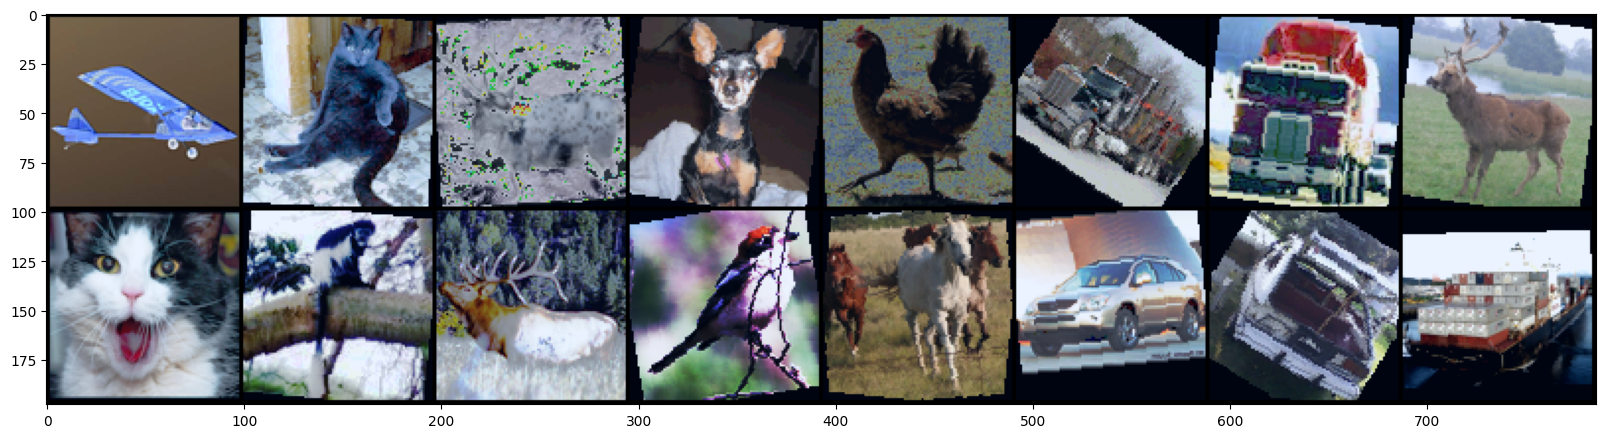

In [12]:
plt.figure(figsize = (20,10))
images, labels = next(iter(model_trainer.train_loader))
out = torchvision.utils.make_grid(images[0:16], normalize=True)
_ = plt.imshow(out.numpy().transpose((1, 2, 0)))

In [ ]:
# Lets see how many Parameter's our Model has!
num_params = 0
for param in model_trainer.model.parameters():
    num_params += param.flatten().shape[0]
print("This model has %d (approximately %d Million) Parameters!" % (num_params, num_params//1e6))

This model has 11181642 (approximately 11 Million) Parameters!


: 

# Train Model!
Our full training method is now fully contained within the trainner class! Simply run the run_training method and specify how many epochs it should train for!

In [ ]:
model_trainer.run_training(num_epochs=num_epochs)

Epoch:   0%|          | 0/60 [00:00<?, ?it/s]

Training:   0%|          | 0/71 [00:00<?, ?it/s]

Evaluating Train Set:   0%|          | 0/71 [00:00<?, ?it/s]

### At this point use google colab to run notebook

# View Results

In [ ]:
print("The highest validation accuracy was %.2f%%" %(model_trainer.best_valid_acc*100))

In [ ]:
_ = plt.figure(figsize = (10,5))
train_x = np.linspace(0, num_epochs, len(model_trainer.train_loss_logger))
_ = plt.plot(train_x, model_trainer.train_loss_logger)
_ = plt.title("Training Loss")

In [ ]:
_ = plt.figure(figsize = (10,5))
train_x = np.linspace(0, num_epochs, len(model_trainer.train_acc_logger))
_ = plt.plot(train_x, model_trainer.train_acc_logger, c = "y")
valid_x = np.linspace(0, num_epochs, len(model_trainer.val_acc_logger))
_ = plt.plot(valid_x, model_trainer.val_acc_logger, c = "k")

_ = plt.title("Accuracy")
_ = plt.legend(["Training accuracy", "Validation accuracy"])

# Evaluate

In [ ]:
# Call the evaluate function and pass the evaluation/test dataloader etc
test_acc = model_trainer.evaluate_model(train_test_val="test")
print("The Test Accuracy is: %.2f%%" %(test_acc*100))